# Face Detection with YOLO V8 Algorithm

```text
- In this project, we are implementing face detection using the YOLO algorithm. We are using the Face-Detection-Dataset for this work. However, instead of using the entire dataset, we are working with approximately 1000 samples for the training set and about 500 samples for the validation set to reduce computational cost. You can find the link to this dataset in the READ.me file.
```


```text
- To ensure the data can be read correctly, we need a file structure like the one below. It is very important that each image file has the same name as its corresponding txt file.
```

```text
dataset/
│── images/
│   ├── train/    # Images for training
│   │   ├── img1.jpg
│   │   ├── img2.jpg
│   │   ├── ...
│   ├── val/      # Images for validation
│   │   ├── img101.jpg
│   │   ├── img102.jpg
│   │   ├── ...
│
│── labels/
│   ├── train/    # Labels for training (Same name .txt files)
│   │   ├── img1.txt
│   │   ├── img2.txt
│   │   ├── ...
│   ├── val/      # Labels for validation
│   │   ├── img101.txt
│   │   ├── img102.txt
│   │   ├── ...
```

```text
- The txt files stored in the data are annotation files and serve as labels showing the locations of faces. These files must be in YOLO format.
- The format expected by YOLO is as follows:

- ``` <class_id> <x_center> <y_center> <width> <height> ```

- Since our dataset is in this format, no preprocessing is required. However, in some datasets, you may find values like X_min and X_max instead of x_center and y_center. In such cases, we need to perform the following transformation:

``` 
    x_min = (x_center - (width / 2)) * image_width
    x_max = (x_center + (width / 2)) * image_width
    y_min = (y_center - (height / 2)) * image_height
    y_max = (y_center + (height / 2)) * image_height
```
```

### **Importing Necessary Libraries**

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import torch
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
from torchvision import transforms
from PIL import Image, ImageDraw
from PIL import ImageFilter
from scipy.spatial.distance import cosine, euclidean # Used only for Face Recognition
from torch.utils.data import DataLoader, Dataset
from ultralytics import YOLO
from facenet_pytorch import InceptionResnetV1 # Used only for Face Recognition
from scipy.signal import savgol_filter


### **Preparing YOLO Format Data with PyTorch Dataset**

At this stage, **we structured our YOLO-formatted dataset as a PyTorch Dataset class** and created a `Dataset` class to process the data.  

1. **We defined the `FaceDetection` class**, which loads images and label files, making them suitable for model training.  

2. **We retrieved the paths of image and label files in an ordered manner**, ensuring that each image corresponds to its respective label file.  

3. **In the `__getitem__` method**, we loaded the image, converted it to `RGB` format, and read the data from the label file, converting the YOLO-formatted coordinates into a NumPy array.  

4. **If a transformation (`transform`) was defined**, we applied the appropriate preprocessing to the image.  

**With this step, we can easily process our dataset using PyTorch's `DataLoader` class and utilize it for model training.** 

In [ ]:

class FaceDetection(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.transform = transform

        self.image_paths = sorted ([os.path.join(image_folder, image_path) for image_path in os.listdir(image_folder)])
        self.annotation_paths = sorted ([os.path.join(annotation_folder, annotation_path) for annotation_path in os.listdir(annotation_folder)])

    def __len__(self):
        return len(self.image_paths)
    
    def __get__item(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')

        annotation_path = self.annotation_paths[idx]

        with open(annotation_path, 'r') as f:
            labels = f.readlines()
        labels = [label.strip() for label in labels if label.strip()]

        boxes = []

        for label in labels:
            label = label.split()
            class_id = int(label[0])
            x_center, y_center, box_width, box_height = map(float, label[1:])
            boxes.append([class_id, x_center, y_center, box_width, box_height])
        boxes = np.array(boxes)

        if self.transform:
            img = self.transform(img)

        return img, boxes
    

image_folder = r"path_to_image_folder"
annotation_folder = r"path_to_annotation_folder"


### **Data Preprocessing and DataLoader Setup**

```text
In this stage, we preprocess the data by applying a series of transformations to the images. First, we resize all images to a consistent size of 640x640 pixels, then convert them into tensors, and finally normalize them using predefined mean and standard deviation values. Afterward, we create a custom dataset for face detection and set up a DataLoader to efficiently load the data in batches, ensuring smooth training with parallel data loading.
```

In [ ]:
transform = transforms.Compose([
    transforms.Resize((640,640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FaceDetection(image_folder, annotation_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

```text
In this step, we create a YAML file that contains the paths to our training and validation datasets, along with the class names and number of classes. We then load the YOLOv8 model and freeze all of its layers to prevent them from updating during training, except for the last layer, which we unfreeze. Finally, we proceed to train the model using the specified parameters, such as the number of epochs, image size, batch size, and optimizer settings.

We freeze all layers except for the last one to leverage the pre-trained features from the earlier layers of the model. The initial layers of a pre-trained model typically capture general features like edges and textures, which are useful across various tasks. By freezing these layers, we avoid overfitting and save computational resources. We unfreeze the last layer because it's responsible for task-specific predictions, and we need to fine-tune it to adapt to our particular dataset and class labels.

In [ ]:

# Create the YAML file
data = {
    'train': r"path_to _training_folder",
    'val': r"path_to_validation_folder",
    'nc': 1,
    'names': ['face']
}

with open("data.yaml", 'w') as yaml_file:
    yaml.dump(data, yaml_file)

# Load the YOLO model
model = YOLO('yolov8n.pt')

# Freeze all layers
for param in model.model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
# Examine the layers in the PyTorch model
last_layer = list(model.model.children())[-1]  # Get the last layer
for param in last_layer.parameters():
    param.requires_grad = True

# Train the model
model.train(
    data='data.yaml',  # Path to the YAML file
    epochs=20,          # Number of training epochs
    imgsz=640,          # Image size
    batch=8,            # Batch size
    lr0=0.001,          # Learning rate
    lrf=0.001,          # Learning rate factor
    optimizer='AdamW'
)

![Image](https://raw.githubusercontent.com/yunusgrgz1/face-detection-with-yolo/refs/heads/main/images%20and%20outputs/evaluation.png)


### **Interpreation of Metrics**
Here’s a brief explanation of each parameter:

1. **Epoch**: A complete pass through the entire training dataset. Multiple epochs help the model improve by iterating over the data.
  
2. **GPU_mem**: The amount of GPU memory used during training, showing how much memory is consumed by the model and data for each batch.

3. **Box_loss**: The loss related to the predicted bounding boxes. It measures how well the predicted boxes match the true boxes.

4. **Cls_loss**: Classification loss that shows how accurately the model classifies objects within the bounding boxes, comparing predicted class probabilities to true labels.

5. **DFL_loss**: Distribution Focal Loss, a variant of focal loss that focuses on harder predictions, especially for rare or difficult examples.

6. **Instances**: The number of detected objects or bounding boxes predicted in an image.

7. **Size**: The image size used for training, impacting both model performance and memory usage.

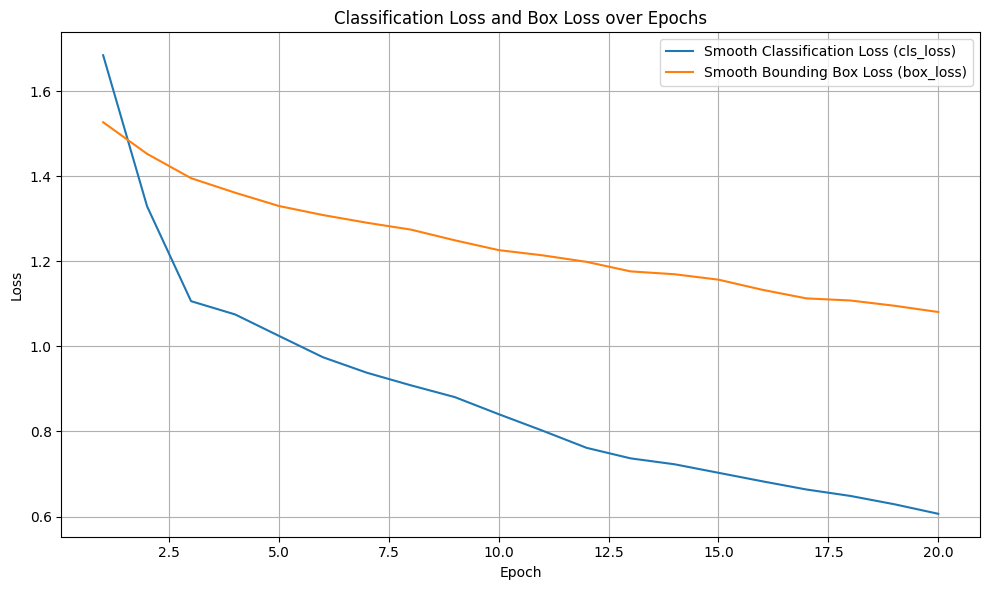

In [ ]:
# Reading the CSV file
file_path = r"csv_file_path"
df = pd.read_csv(file_path)

# Extracting 'cls_loss' and 'box_loss' values from the 'Epoch' column
epochs = df['Epoch']
cls_loss = df['cls_loss']
box_loss = df['box_loss']

# Smoothing the losses using the Savitzky-Golay filter
smooth_cls_loss = savgol_filter(cls_loss, window_length=5, polyorder=2)
smooth_box_loss = savgol_filter(box_loss, window_length=5, polyorder=2)

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, smooth_cls_loss, label='Classification Loss (cls_loss)')
plt.plot(epochs, smooth_box_loss, label='Bounding Box Loss (box_loss)')

# Title and labels
plt.title('Classification Loss and Box Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### **Testing the Model**


image 1/1 C:\1\Yazilim\Machine Learning\Github Projeleri\Face Detection and Recognition\pexels-hillaryfox-1595391.jpg: 448x640 7 faces, 53.1ms
Speed: 4.6ms preprocess, 53.1ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)


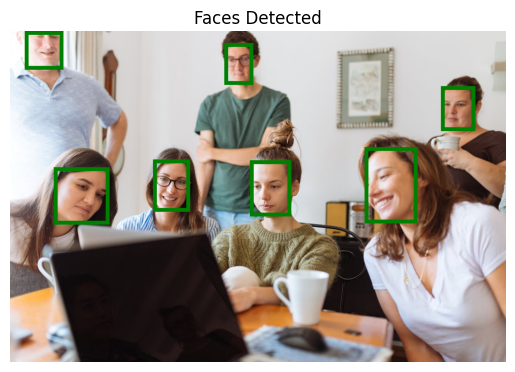

In [ ]:

def detect_face(image_path, model):
    # Open the image using PIL
    image = Image.open(image_path)

    # Make predictions using the YOLO model
    results = model.predict(source=image_path, conf=0.5, save=False)
    boxes = results[0].boxes.xyxy  # Get the bounding boxes

    draw = ImageDraw.Draw(image)  # For drawing on the image

    # Draw green rectangles around the faces
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box.tolist())
        # Draw a green rectangle around the face
        draw.rectangle([x_min, y_min, x_max, y_max], outline="green", width=10)

    return image

# Load the model
model = YOLO(r"path_to_best_model")  # Model saved at the end of training
image_path = r"random_image_path"

# Detect faces and draw rectangles
image_with_boxes = detect_face(image_path, model)

# Display the image using matplotlib
plt.imshow(image_with_boxes)  # Show as PIL Image
plt.title("Faces Detected")
plt.axis('off')  # Turn off axes
plt.show()

### **Testing the Model by Accessing the Webcam**

- We can also use our model through the `cv2` (Computer Vision) library by accessing our computer's webcam or by uploading a video.

In [ ]:

# Load the trained model
model = YOLO(r"path_to_best_model")

# Start the webcam (0 is the default camera)
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Apply the YOLO model to the frame
    results = model.predict(source=frame, conf=0.5, save=False)

    # Draw only the boxes (without labels)
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # Box coordinates
        frame = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Draw the box

    # Display the output on the screen
    cv2.imshow("YOLO Face Detection", frame)

    # Wait for 'q' key to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


![GIF Preview](https://github.com/yunusgrgz1/face-detection-with-yolo/blob/main/images%20and%20outputs/webcam_output.gif?raw=true)


In [ ]:

# Load the trained model
model = YOLO(r"path_to_best_model")

# Open the video file (e.g., video.mp4)
video_path = r"test_video_file"
cap = cv2.VideoCapture(video_path)

# Create a VideoWriter object for saving the output video
# Set output video name, codec, FPS, and resolution
output_video_path = r"output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for MP4 format
fps = cap.get(cv2.CAP_PROP_FPS)  # Original video's FPS
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize VideoWriter
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Apply YOLO model to the frame
    results = model.predict(source=frame, conf=0.5, save=False)

    # Annotate the frame with bounding boxes (only boxes)
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # Get box coordinates
        frame = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Draw the box

    # Display the output
    cv2.imshow("YOLO Face Detection", frame)

    # Save the annotated frame to the output video
    out.write(frame)

    # Wait for 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()  # Release the video writer
cv2.destroyAllWindows()


![GIF Preview](https://github.com/yunusgrgz1/face-detection-with-yolo/blob/main/images%20and%20outputs/video_output_low_res.gif?raw=true)



### END